# Aprendizaje de una observación: Red Siamesa


En este ejemplo abordaremos la tarea de verificación de rostros con una observacvión empleando una Red Siamesa.

## Bibliotecas

In [1]:
%matplotlib inline
# funciones aleatorias
from itertools import islice as take
import random
import os

# graficación
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
# image processing
from skimage import io
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets.utils import extract_archive
from torchvision.datasets.utils import download_file_from_google_drive
from PIL import Image

# progress bar
from tqdm import trange

# reproducibilidad
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [2]:
# tamaño del lote
BATCH_SIZE = 64

## Ayudantes

In [3]:
def to_numpy(x):
     # convertimos el tensor a ndappray
     x = x.numpy()
     # eliminamos dimensión extra
     x = np.squeeze(x)
     # píxeles de 0 a 255    
     x = (x * 255).astype(np.uint8)
     return x

## Datos

### AT&T Faces

AT&T Faces es un conjunto de datos de imágenes de rostos. Contiene 10 fotografías diferentes por cada uno de los 40 sujetos distintos en en el conjunto. Las imágenes fueron tomadas en diferentes momentos, variando la iluminación, las expresiones faciales (ojos abiertos / cerrados, sonriendo / sin sonreír) y algunos otros detalles (anteojos / sin anteojos). Todas las imágenes fueron tomadas contra un fondo oscuro y homogéneo  estando los sujetos en posición vertical y frontal con tolerancia a algún movimiento lateral.

### Dataset

Contruimos un Dataset que nos permita obtener parejas de imágenes de rostos de un mismo individuo y parejas de individuos diferentes.

In [4]:
class FacesDataset:
    
    data_dir = 'data'
    file_id = '1loJnEcRpPE7_1rAKtZnWsQNtLJ0nlXmC'
    filename = 'atnt-faces.tar.gz'

    def __init__(self, train, tsfm=None, ):

        self._download()
        
        # elegimos los datos de entr o val
        subset = 'trn' if train else 'val'
        # ruta al conjunto de datos 
        base_dir = os.path.join(self.data_dir, 'atnt-faces', subset)
        # lista de los sujetos 
        subjects = sorted(os.listdir(base_dir))
        data = {}
        for subject in subjects:
            # ruta a los sujetos 
            sub_dir = os.path.join(base_dir, subject)
            # lista de las imágenes por sujeto
            data[subject] = sorted(os.listdir(sub_dir))
        
        self.base_dir = base_dir
        self.data = data
        self.tsfm = tsfm
        self.size = 400

    def _download(self):
      # ruta para descargar datos
      file_path = os.path.join(self.data_dir, self.filename)
      # revisamos que no esten descargados
      if not os.path.isfile(file_path):
          # descarga de Drive
          download_file_from_google_drive(
              self.file_id, 
              self.data_dir, 
              filename=self.filename
          )
          # Descomprimimos el archivo
          extract_archive(file_path)

    def __getitem__(self, i):
        
        # elegimos aleatoriamente si son similares (1) o no (0)
        sim = random.randint(0, 1)
        
        #similares
        if sim:
            # elegimos un sujeto al azar
            subject = random.choice(list(self.data.keys()))
            # elegimos dos imágenes distintas del sujeto
            a, b = random.sample(self.data[subject], 2)
            # leemos las imágenes
            a = io.imread(os.path.join(self.base_dir, subject, a))
            b = io.imread(os.path.join(self.base_dir, subject, b))
        
        # disimilares
        else:
            # elegimos dos sujetos al azar sin repetición
            subject_a, subject_b = random.sample(self.data.keys(), 2)
            # elegimos una imagen del sujeto a
            a = random.choice(self.data[subject_a])
            # elegimos una imagen del sujeto b
            b = random.choice(self.data[subject_b])
            # leemos las imágenes
            a = io.imread(os.path.join(self.base_dir, subject_a, a))
            b = io.imread(os.path.join(self.base_dir, subject_b, b))
        
        if self.tsfm is not None:
            # aplicamos las transformaciones a las imágenes
            a = self.tsfm(a)
            b = self.tsfm(b)
        
        # etiqueta para la pareja
        y = np.array(sim, dtype=np.float32)
        
        return a, b, y

    def __len__(self):
        return self.size

In [5]:
ds = FacesDataset(
    train=True, 
    tsfm=transforms.Compose([
        # convertimos a pillow
        Image.fromarray,
        # redimensionamos
        transforms.Resize([100,100]),
        # convertimos la imagen a un arreglo numpy
        np.array
    ])
)

a shape=(100, 100), dtype=uint8
b shape=(100, 100), dtype=uint8
y shape=(), dtype=float32 1.0


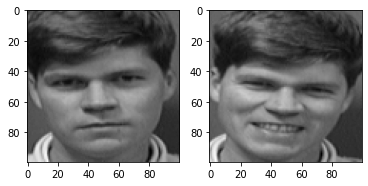

a shape=(100, 100), dtype=uint8
b shape=(100, 100), dtype=uint8
y shape=(), dtype=float32 1.0


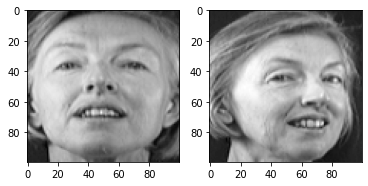

a shape=(100, 100), dtype=uint8
b shape=(100, 100), dtype=uint8
y shape=(), dtype=float32 1.0


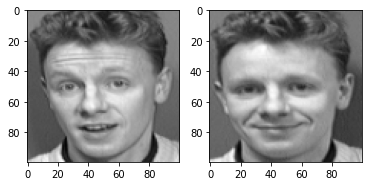

a shape=(100, 100), dtype=uint8
b shape=(100, 100), dtype=uint8
y shape=(), dtype=float32 1.0


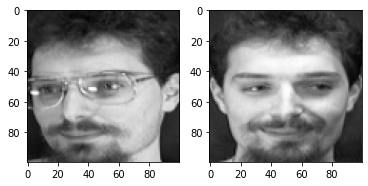

a shape=(100, 100), dtype=uint8
b shape=(100, 100), dtype=uint8
y shape=(), dtype=float32 0.0


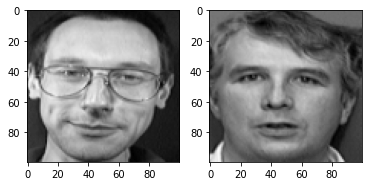

a shape=(100, 100), dtype=uint8
b shape=(100, 100), dtype=uint8
y shape=(), dtype=float32 1.0


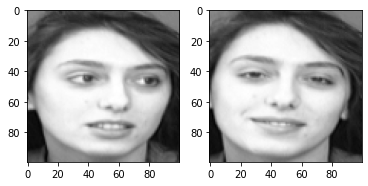

In [6]:
# exploración del conjunto usando el Dataset
for _ in range(6):
    # se obtiene un par de imágenes junto con su etiqueta
    a, b, y = ds[0]
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'y shape={y.shape}, dtype={y.dtype} {y}')
    io.imshow_collection([a, b], cmap='gray')
    io.show()

### Dataloaders

In [7]:
# Dataset para entrenamiento
trn_ds = FacesDataset(
    # etapa de entrenamiento
    train=True, 
    # definimos las transformaciones
    tsfm=transforms.Compose([
        # convertimos a pillow
        Image.fromarray,
        # redimensionamos
        transforms.Resize([100,100]),
        # convertimos a tensor
        transforms.ToTensor()
    ])
)

# DataLoader para entrenamiento
trn_dl = DataLoader(
    # dataset de entrenamiento
    trn_ds, 
    # barajeamos 
    shuffle=True,
    # tamaño del lote
    batch_size=BATCH_SIZE
)

# obtenemos un lote
for a, b, y in take(trn_dl, 1):
    # verificamos dimensiones y tipo
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'y shape={y.shape}, dtype={y.dtype}')

a shape=torch.Size([64, 1, 100, 100]), dtype=torch.float32
b shape=torch.Size([64, 1, 100, 100]), dtype=torch.float32
y shape=torch.Size([64]), dtype=torch.float32


In [8]:
# Dataset de validación
val_ds = FacesDataset(
    # fase de validación
    train=False, 
    # se definen las transformaciones
    tsfm=transforms.Compose([
        # convertimos a pillow
        Image.fromarray,
        # redimensionamos
        transforms.Resize([100,100]),
        # convertimos a tensor
        transforms.ToTensor()
    ])
)

# DataLoader para validación
val_dl = DataLoader(
    # Dataset de validación
    val_ds, 
    # barajeamos
    shuffle=True,
    # tamaño del lote
    batch_size=BATCH_SIZE
)

# obtenemos un lote
for a, b, y in take(val_dl, 1):
    # verificamos dimensiones y tipo
    print(f'a shape={a.shape}, dtype={a.dtype}')
    print(f'b shape={b.shape}, dtype={b.dtype}')
    print(f'y shape={y.shape}, dtype={y.dtype}')

a shape=torch.Size([64, 1, 100, 100]), dtype=torch.float32
b shape=torch.Size([64, 1, 100, 100]), dtype=torch.float32
y shape=torch.Size([64]), dtype=torch.float32


## Modelo: Red Siamesa
We will use a standard convolutional neural network

In [9]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.cnn = nn.Sequential(
            # bloque convolucional 1
            # [N, 1, 100, 100] => [N, 4, 100, 100]
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            # [N, 4, 100, 100]
            nn.ReLU(),
            # [N, 4, 50, 50]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 4, 50, 50]
            nn.BatchNorm2d(4),
            
            # bloque convolucional 2
            # [N, 4, 50, 50] => [N, 8, 50, 50]
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1),
            # [N, 8, 50, 50]
            nn.ReLU(),
            # [N, 8, 50, 50] => [N, 8, 25, 25]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 8, 25, 25]
            nn.BatchNorm2d(8),

            # bloque convolucional 3
            # [N, 8, 25, 25] => [N, 16, 25, 25]
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            # [N, 16, 25, 25]
            nn.ReLU(),
            # [N, 16, 25, 25] => [N, 16, 12, 12]
            nn.MaxPool2d(kernel_size=2, stride=2),
            # [N, 16, 12, 12]
            nn.BatchNorm2d(16),
        )

        self.fc = nn.Sequential(
            # bloque completamente conectado 1
            # [N, 16x12x12] => [N, 512]
            nn.Linear(16 * 12 * 12, 512),
            # [N, 512]
            nn.ReLU(),
            # bloque completamente conectado 2
            # [N, 512] => [N, 16]
            nn.Linear(512, 16)
        )

    def forward_one(self, x):
        # [N, 1, 100, 100] => [N, 16, 12, 12]
        x = self.cnn(x)
        # [N, 16, 12, 12] => [N, 16x12x12]
        x = x.view(x.shape[0], -1)
        # [N, 16x12x12] => [N, 16]
        x = self.fc(x)
        return x

    def forward(self, a, b):
        # [N, 1, 100, 100] => [N, 16]
        a = self.forward_one(a)
        # [N, 1, 100, 100] => [N, 16]
        b = self.forward_one(b)
        return a, b

# imprimimos la arquitectura
print(SiameseNet())

SiameseNet(
  (cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=16, bias=True)
  )
)


## Pérdida Contrastiva

In [10]:
def contrastive_loss(a, b, y, margin=10.0):
    # se obtiene la distancia por pares del lote
    d = F.pairwise_distance(a, b)
    # se calcula el error cuando las imágenes son del mismo sujeto
    loss1 = y * d ** 2
    # se calcula el error cuando las imágenes son de un sujeto distinto
    loss2 = (1 - y) * torch.clamp(margin - d, min=0) ** 2
    # se obtiene la pérdida para el lote
    loss = torch.mean(loss1 + loss2)
    return loss

## Entrenamiento

In [11]:
# instanciamos el modelo
model = SiameseNet()
# optimizador
opt = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# historial de pérdida 
loss_history = [] 
# épocas de entrenamiento
epochs = 15
for epoch in trange(epochs):
    # entrenamiento por lotes
    for i, (a, b, y) in enumerate(trn_dl):
        # se los gradientes anteriores
        opt.zero_grad()
        # inferencia 
        a, b = model(a, b)
        # cómputo de  la pérdida
        loss = contrastive_loss(a, b, y)
        # cálculo de los gradientes
        loss.backward()
        # optimización del modelo
        opt.step()
        # se agrega la pérdida al historial
        loss_history.append(loss.item())

100%|██████████| 15/15 [00:38<00:00,  2.55s/it]


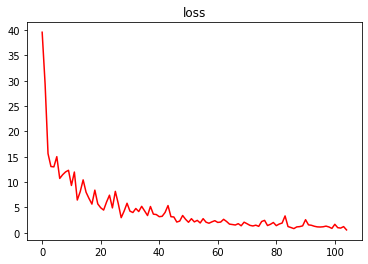

In [13]:
# graficamos el historial de pérdida 
plt.plot(loss_history, 'r')
plt.title('loss')
plt.show()

## Evaluación

In [14]:
# modelo en modo de evaluación
model.eval()
# historial de pérdida
loss_history = []
# inferencia sin gradientes
with torch.no_grad():
    for i, (a, b, y) in enumerate(val_dl):
        # inferencia
        a, b = model(a, b)
        # cálculo de pérdida
        loss = contrastive_loss(a, b, y)
        # agregamos al historial
        loss_history.append(loss.item())

# cálculamos la pérdida del lote
total_loss = np.mean(loss_history)
print(total_loss)

4.0999241556440085


Distancia: 3.94


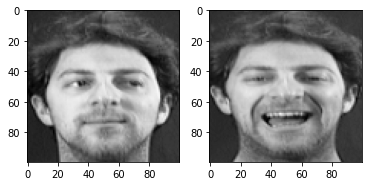

Distancia: 2.3


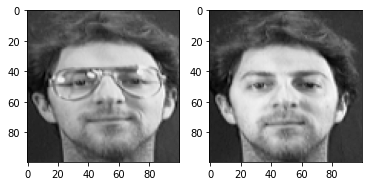

Distancia: 1.91


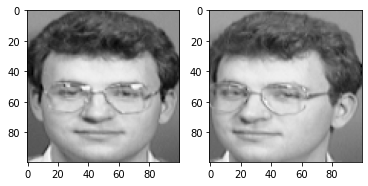

Distancia: 11.24


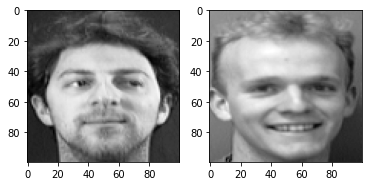

Distancia: 10.13


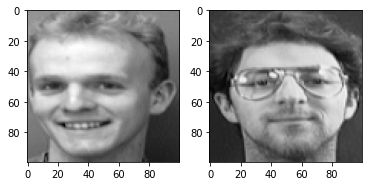

Distancia: 9.52


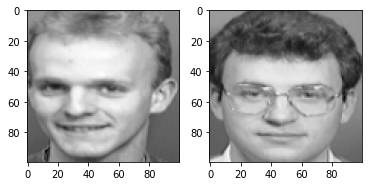

In [15]:
# inferencia sin gradientes
with torch.no_grad():
    for _ in range(6):
        # obtenemos una pareja de imágenes
        a, b, _ = val_ds[0]
        
        # convertimos las imagenes a ndarray
        img_a = to_numpy(a)
        img_b = to_numpy(b)
        
        # agregamos una dimensión 
        a = torch.unsqueeze(a, 0)
        b = torch.unsqueeze(b, 0)
        
        # inferencia
        a, b = model(a, b)

        # cálculamos la distancia
        d = F.pairwise_distance(a, b)

        print(f'Distancia: {round(d.item(), 2)}')

        io.imshow_collection([img_a, img_b], cmap='gray')
        io.show()